# F21DL - ML Portfolio Coursework 
### MIT Places Dataset for identifying places using computer vision
#### Rucha Tare
#### Maxime Mavel
#### Daniel Eneh
#### Aureline Lohmann


## Step 1 - Data Sourcing: 
We chose MIT places mini dataset from below 4 datasets 

1. Bird species classification - BIRDS 400 - SPECIES IMAGE CLASSIFICATION | Kaggle (Links to an external site.)
     
     Source: Kaggle

     Data Description: Data helps to predict bird species with help of images and attributes tagged to images. Data has species of 400 birds and number of images for each species. It also has attributes like height, weight of the image used, name of the bird and class of the bird species. The data is already divided into test and train folders. It has 400 instances

2. Australian Sign Language: UCI Machine Learning Repository: Australian Sign Language signs Data Set (Links to an external site.)

   Source: UCL Machine Learning Repository

   Data description: Data has x,y,z coordinate measurements of a Nintendo Glove that helps to predict that Australian Sign Language. The data has 15 attributes related to positions of the co-ordinate and images with 6650 instances

3. Movie Genre prediction from its posters: Movie Genre from its Poster | Kaggle (Links to an external site.)
 Source - Kaggle

 Description of the data: This dataset has images of the movie posters and movie attributes like IMDB ID, IMDB link, Genre, Ranking. It has 998 instances.

Pros: 
1. Has combination of images and attributes 
2. Since we have a lot of movie posters on internet, we can tweak data sets to add more instances if needed or manipulate the data
3. We can test the model on newer poster every time so that it actually predicts accurate results as compared to above bird or sign languages.
Attributes have link, text,number, floats to play around with


4. MIT places Mini dataset: We later found this MIT places mini dataset which is a great places dataset originally created by MIT AI researchers. It has 100,000 images labelled. We have taken subset of it not all the dataset hence it is called mini MIT places 
http://dl.caffe.berkeleyvision.org/mit_mini_places/

Source : Google

Pros of this dataset :

1. More number of instances

2. Credible datasets by MIT researchers

3. More number of features will help us learn and explore more

4. Versatile dataset that can be played around with many applications and things are it identifying places and scenes 

Cons with First three datasets:

1. Creating new data will be troublesome as we don't have images and attributes.

2. Australian sign language attributes are just coordinates so it is not much to play around with, similar to the bird dataset that mostly has numbers and two text columns

3. Movie was a great dataset but number of instances were 998 only. 

Conclusion: Due to above cons we decided to choose the MIT places dataset

GITLAB Repo link :  https://gitlab-student.macs.hw.ac.uk/rt2026/ml-portoflio-mit-places

### 1.1 - Importing Relevant Libraries and data options

In [4]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
#Importing needed libraries to python
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from collections import Counter

#import CV
import cv2

# sklearn imports
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Configurations for the dataset
#### Note: I have deleted the object file and also combined the category and image in same directory called ML_portfolio_Data. Please change the path as you have saved your dataset

In [5]:
category_dir = 'C:/ML_Portfolio_Data/Labels/'
image_dir = 'C:/ML_Portfolio_Data/data/images/'

In [6]:
categories_txt = 'categories.txt'
train_txt= 'train.txt'
val_txt= 'val.txt'
path_train= category_dir + train_txt
path_val = category_dir + val_txt 

## Step 2 - Data Loading and Data preprocessing

Data Description: 
 categories.txt - 0-99 categories

 train.txt - training dataset to categorise images

 training data images- 100,000 Images for all the 0-99 categories

 val data images - validation dataset has 10,000 images

 val.txt - Has categories for validation images
 
 
 

### Creating Category Dataset

In [7]:
categories_file = open(f'{category_dir}{categories_txt}', 'r') 
category_records = categories_file.readlines()
categories_file.close()

##### We are creating a dictionary for category that will have category id and category record so that we can later verify the category name with the id. Since few categories also have sub categories in them e.g /i/ice_skating_rink/outdoor 56 we are replacing "/" to "-". So that we get the prediction as  ice_skating_rink - outdoor

In [8]:
categories_dataset = {}
for category_record in category_records:
    category_name, category_id = category_record.split(" ")
    category_name = category_name[3:].replace('/','-')
    
    categories_dataset[int(category_id)] = category_name

### Image Preprocessing

In [9]:
#checking the image path to verify 
print(f'{image_dir}/train/a/abbey/00000001.jpg')

C:/ML_Portfolio_Data/data/images//train/a/abbey/00000001.jpg


In [10]:
#reading a test image for two reasons: 1. Checking the image 2. Using the image to take 80% of its dimensions to scale 
test_image = cv2.imread(f'{image_dir}/train/a/abbey/00000001.jpg', cv2.IMREAD_COLOR)

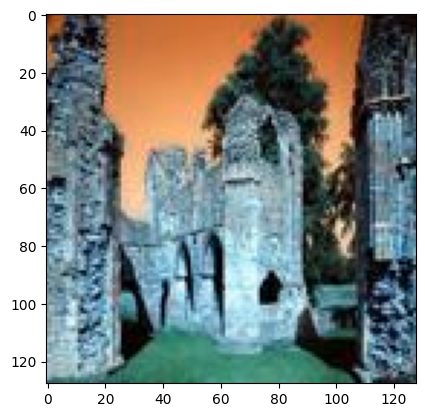

In [11]:
#checking the image plot for test image
plt.imshow(test_image)
plt.show()

In [12]:
# getting the 80% size for image for further preprocessing
SCALE_PERCENT = 80 
WIDTH = int(test_image.shape[1] * SCALE_PERCENT / 100)
HEIGHT = int(test_image.shape[0] * SCALE_PERCENT / 100)
DIM = (WIDTH, HEIGHT)

#printing the scaled size of the test image. We will use these dimensions in the below function while scaling train and val images
print("Scaled image size should be: ", DIM)

Scaled image size should be:  (102, 102)


In [13]:
def image_resize(image):
    """
    Function to define resizing images. This will be called from image_preprocess
    Args: 
    image list - list of images
    returns"
    imnage_rs list - List of images resized 
    """
    image_rs = cv2.resize(image, DIM, interpolation=cv2.INTER_AREA)

    return image_rs        

In [14]:
def image_to_array(images):
    """
    Defining function to convert images to array
    Args:
    images - list of images
    returns:
    images_arr_rs - array of reshaped images
    """
    # Data Normalization
    images = np.array(images)
    images = images.astype('float32') 
    # Normalization
    images = images/255.0
    images_arr_rs = images.reshape((len(images), -1))

    return images_arr_rs

##### Using cv2 to read images. We are storing image path in case we need it for further use. We will have list of images, categories and image paths

In [15]:
def preprocess_image(image_dir, category_path):
    """
    Defining a function to read, resize images and categories
    Args:
    image_dir - image_dir to read images from
    category_path - category path to read categories
    """
    images = []
    image_paths = []
    categories = []
    file = open(category_path, 'r') 
    label_records = file.readlines()
    file.close()

    for record in label_records:
        # split each line on label file using spaces into image path and category id
        image_path, category = record.split(" ")  

        # load images and resize
        image_w= cv2.imread(f'{image_dir}/{image_path}', cv2.IMREAD_COLOR)
        image_bw = cv2.cvtColor(image_w, cv2.COLOR_BGR2GRAY)
        image = image_resize(image_bw)
        
        # load filenames as a list
        image_paths.append(f'{image_dir}/{image_path}')

        # adding image and category to the list
        images.append(image)
        categories.append(int(category))
        
    return images, categories, image_paths

abbey


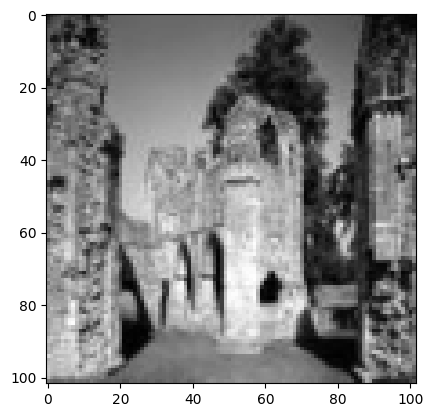

In [16]:
# getting train dataset by calling preprocess and plotting a train image and verifying its category
images_train, category_train, image_paths_train = preprocess_image(image_dir, path_train)
print(categories_dataset[category_train[0]])
plt.imshow(images_train[0], cmap='gray')
plt.show()

palace


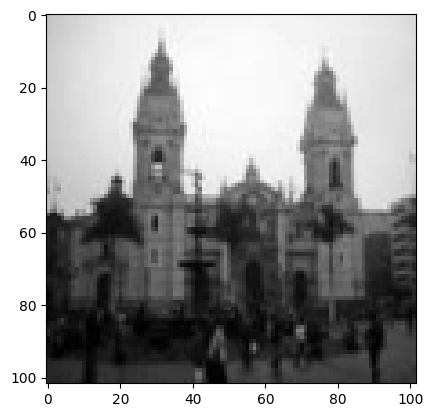

In [17]:
# # getting validation dataset by calling preprocess and plotting a val image and verifying its category
images_val, category_val, image_paths_val = preprocess_image(image_dir, path_val)
print(categories_dataset[category_val[0]])
plt.imshow(images_val[0], cmap='gray')
plt.show()

In [18]:
#Calling images to array and getting X train, Y train, X val , Y val
X = image_to_array(images_train)
y = pd.DataFrame(category_train, columns=['category'])
X_val = image_to_array(images_val)
y_val = pd.DataFrame(category_val, columns=['category'])

In [19]:
X_train, X_train_inventory, y_train, y_train_inventory = train_test_split(X, y, test_size=0.70, random_state=42, stratify=y)

In [20]:
X_val, X_val_inventory, y_val, y_val_inventory = train_test_split(X_val, y_val, test_size=0.60, random_state=42, stratify=y_val)

In [21]:
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)

X_train Shape:  (30000, 10404)
y_train Shape:  (30000, 1)
X_val Shape:  (4000, 10404)
y_val Shape:  (4000, 1)


## Classification 

In [22]:
sgd_clf = SGDClassifier(max_iter=10, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(max_iter=10, random_state=42)

In [23]:
SGDClassifier(random_state=42)
sgd_clf.predict(X_val)

array([62, 61, 46, ..., 61, 61, 77], dtype=int64)

In [24]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.0191, 0.0135, 0.0194])

### Multinomial NB

In [25]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train, y_train)

MultinomialNB()

In [26]:
model_MNB.predict(X_val)

array([94, 46,  2, ..., 36, 98, 56], dtype=int64)

In [27]:
cross_val_score(model_MNB, X_train, y_train, cv=3, scoring="accuracy") 

array([0.0308, 0.0319, 0.0314])

In [28]:
y_pred_MNB = cross_val_predict(model_MNB, X_val, y_val, cv=3)
confusion_matrix(y_val, y_pred_MNB)

array([[ 0,  0,  0, ...,  6,  7,  0],
       [ 1,  0,  1, ...,  2,  2,  0],
       [ 0,  0,  0, ...,  3,  2,  1],
       ...,
       [ 0,  0,  0, ...,  7, 10,  1],
       [ 1,  0,  0, ...,  7,  7,  0],
       [ 0,  1,  1, ...,  4,  3,  0]], dtype=int64)

### Gaussian NB

In [29]:
model_GNB = GaussianNB()
model_GNB.fit(X_train, y_train)

GaussianNB()

In [30]:
y_pred_GNB = model_GNB.predict(X_val)
cross_val_score(model_GNB, X_train, y_train, cv=3, scoring="accuracy")

array([0.0451, 0.0434, 0.0423])

In [31]:
y_pred_GNB = cross_val_predict(model_GNB, X_val, y_val, cv=3)
confusion_matrix(y_val, y_pred_GNB)

array([[0, 0, 0, ..., 5, 4, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 3, 1, 0],
       ...,
       [0, 0, 0, ..., 9, 5, 0],
       [0, 0, 0, ..., 5, 5, 0],
       [1, 0, 0, ..., 3, 3, 0]], dtype=int64)

### Complement NB

In [32]:
model_CNB = ComplementNB()
model_CNB.fit(X_train, y_train)
y_pred_CNB = model_CNB.predict(X_val)

In [33]:
cross_val_score(model_CNB, X_train, y_train, cv=3, scoring="accuracy")

array([0.0239, 0.0213, 0.0245])

## Clustering

In [34]:
total_clusters = len(np.unique(y_train))

In [35]:
def get_reference_labels(cluster_labels, y, total_clusters):
    """
    """
    # Initializing
    refer_labels = {}
    
    # loop through each label of cluster
    for i in range(total_clusters):
        index = np.where(cluster_labels == i, 1, 0)
        num = np.bincount(y[index == 1]).argmax()
        refer_labels[i] = num
    
    return refer_labels

### Gaussian Mixture

In [36]:
# # Initialize the Gaussian Mixture model
# model_GM = GaussianMixture(n_components=10, random_state=42)

# # Fitting the model to training set
# model_GM.fit(X_train)

# # get the weights of each mixture component
# model_GM_weights = model_GM.weights_

### Minibatch Kmeans Clustering Algorithm

In [37]:
# Initialize the K-Means model
mini_kmeans = MiniBatchKMeans(n_clusters = total_clusters, random_state=42)

# Fitting the model to training set
mini_kmeans.fit(X_train)

# get the cluster labels
mini_kmeans_labels = mini_kmeans.labels_

In [ ]:
y_train_kmeans = y_train["category"].to_numpy()

In [ ]:
reference_labels = get_reference_labels(mini_kmeans_labels, y_train_kmeans, total_clusters)

# defining a dummy list of predicted labels
predicted_labels = np.random.rand(len(mini_kmeans_labels))

for i in range(len(mini_kmeans.labels_)):
    predicted_labels[i] = reference_labels[mini_kmeans_labels[i]]

In [ ]:
print(accuracy_score(predicted_labels, y_train_kmeans))

0.048466666666666665


In [ ]:
print(predicted_labels[:20].astype('int'))
print(y_train_kmeans[:20])

[82 87 87 58 87 15 96 88 10 33  8  8  9  4 87 22 12  8 88 15]
[92 79 86 35 20  7 30 88 19 80 27 92 39  3 87 50 79 77 78 84]


In [ ]:
centroids = mini_kmeans.cluster_centers_
centroids.shape

(100, 10404)

In [ ]:
centroids = centroids.reshape(100, 102, 102)
centroids = centroids * 255

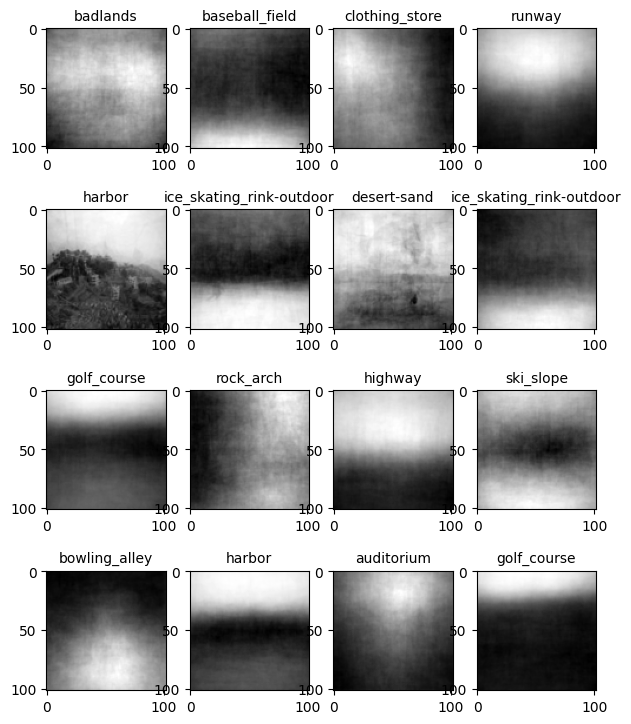

In [ ]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4, 4, i+1)
    plt.title(categories_dataset[reference_labels[i]], fontsize = 10)
    plt.imshow(centroids[i], cmap='gray')

In [ ]:
y_pred = mini_kmeans.predict(X_val)

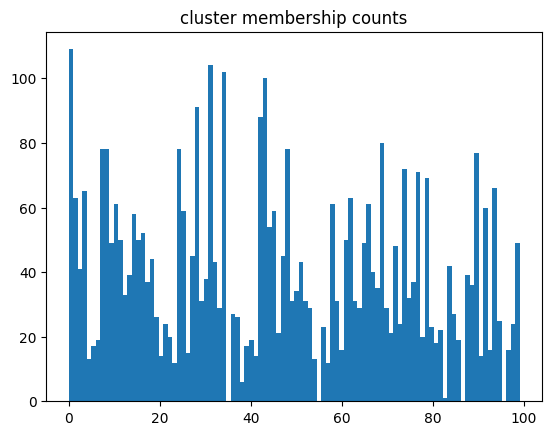

In [ ]:
plt.hist(list(y_pred), bins=total_clusters)
plt.title('cluster membership counts');

In [ ]:
counts = Counter(list(y_pred))
counts.most_common()[0]

(0, 109)

### Kmeans Clustering Algorithm

In [ ]:
# Initialize the K-Means model
kmeans = KMeans(n_clusters = total_clusters, random_state=42)

# Fitting the model to training set
kmeans.fit(X_train)

# get the cluster labels
kmeans_labels = mini_kmeans.labels_

In [ ]:
y_train_kmeans = y_train["category"].to_numpy()

In [ ]:
reference_labels = get_reference_labels(kmeans_labels, y_train_kmeans, total_clusters)

# defining a dummy list of predicted labels
predicted_labels = np.random.rand(len(kmeans_labels))

for i in range(len(mini_kmeans.labels_)):
    predicted_labels[i] = reference_labels[kmeans_labels[i]]

NameError: name 'get_reference_labels' is not defined

In [ ]:
print(accuracy_score(predicted_labels, y_train_kmeans))

In [ ]:
print(predicted_labels[:20].astype('int'))
print(y_train_kmeans[:20])

In [ ]:
centroids = kmeans.cluster_centers_
centroids.shape

In [ ]:
centroids = centroids.reshape(100, 102, 102)
centroids = centroids * 255

In [ ]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4, 4, i+1)
    plt.title(categories_dataset[reference_labels[i]], fontsize = 10)
    plt.imshow(centroids[i], cmap='gray')

In [ ]:
y_pred = kmeans.predict(X_val)

In [ ]:
plt.hist(list(y_pred), bins=total_clusters)
plt.title('cluster membership counts');

In [ ]:
counts = Counter(list(y_pred))
counts.most_common()[0]